<a href="https://colab.research.google.com/github/hamagami/is2024/blob/main/11_VAE_with_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VAE with MNIST
It takes a significant amount of time with the CPU. Please change the runtime type to GPU.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [ ]:
# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor()  # Only use ToTensor() to scale data to [0, 1]
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [ ]:
# Define the Variational AutoEncoder class
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        # Encoder
        self.encoder_fc1 = nn.Linear(28*28, 128)
        self.encoder_fc2_mean = nn.Linear(128, latent_dim)
        self.encoder_fc2_logvar = nn.Linear(128, latent_dim)

        # Decoder
        self.decoder_fc1 = nn.Linear(latent_dim, 128)
        self.decoder_fc2 = nn.Linear(128, 28*28)

    def encode(self, x):
        h1 = torch.relu(self.encoder_fc1(x))
        mean = self.encoder_fc2_mean(h1)
        logvar = self.encoder_fc2_logvar(h1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def decode(self, z):
        h2 = torch.relu(self.decoder_fc1(z))
        return torch.sigmoid(self.decoder_fc2(h2))

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        x_reconstructed = self.decode(z)
        return mean, logvar, z, x_reconstructed

Epoch 1/50, Train Loss: 218.5483, Val Loss: 175.8604
Epoch 2/50, Train Loss: 170.6675, Val Loss: 165.4833
Epoch 3/50, Train Loss: 163.8799, Val Loss: 161.1256
Epoch 4/50, Train Loss: 160.2484, Val Loss: 158.1853
Epoch 5/50, Train Loss: 157.6614, Val Loss: 156.2091
Epoch 6/50, Train Loss: 155.7294, Val Loss: 154.3399
Epoch 7/50, Train Loss: 154.0685, Val Loss: 153.1427
Epoch 8/50, Train Loss: 152.6588, Val Loss: 151.6438
Epoch 9/50, Train Loss: 151.3601, Val Loss: 150.6507
Epoch 10/50, Train Loss: 150.2902, Val Loss: 149.7105
Epoch 11/50, Train Loss: 149.3226, Val Loss: 148.8061
Epoch 12/50, Train Loss: 148.5043, Val Loss: 148.2708
Epoch 13/50, Train Loss: 147.7739, Val Loss: 147.3896
Epoch 14/50, Train Loss: 147.1489, Val Loss: 146.8642
Epoch 15/50, Train Loss: 146.5863, Val Loss: 146.4600
Epoch 16/50, Train Loss: 146.1328, Val Loss: 146.0347
Epoch 17/50, Train Loss: 145.6937, Val Loss: 145.6236
Epoch 18/50, Train Loss: 145.2802, Val Loss: 145.4220
Epoch 19/50, Train Loss: 144.9346, Va

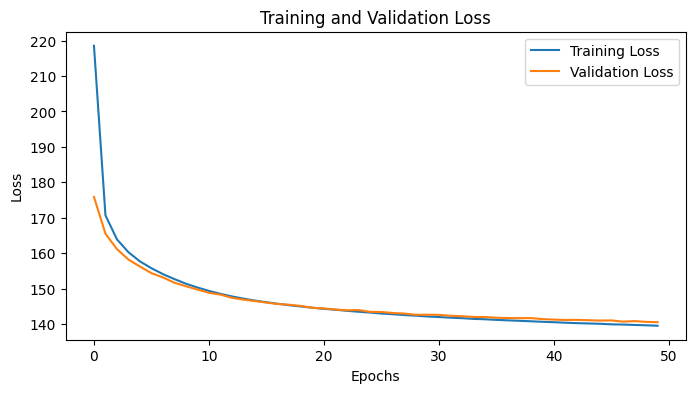

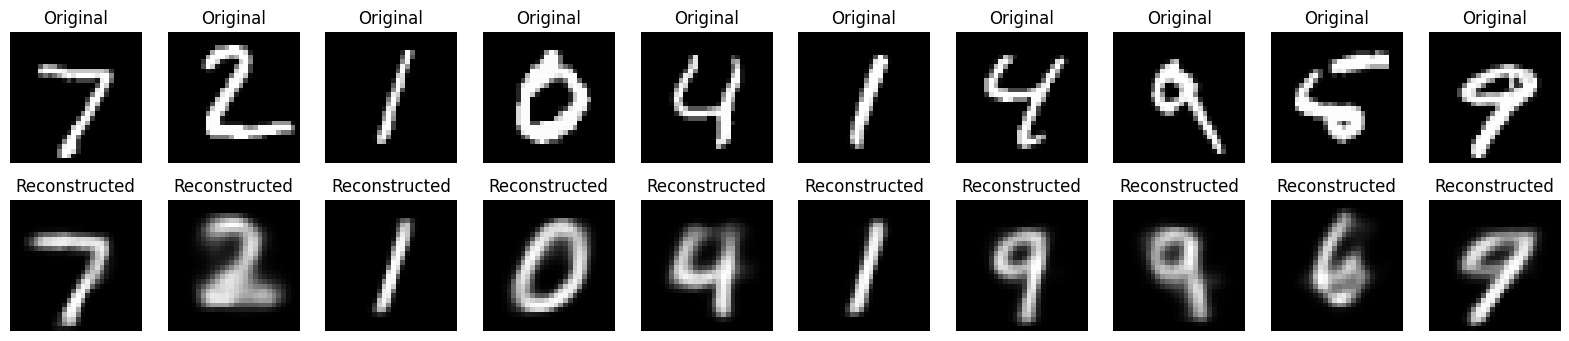

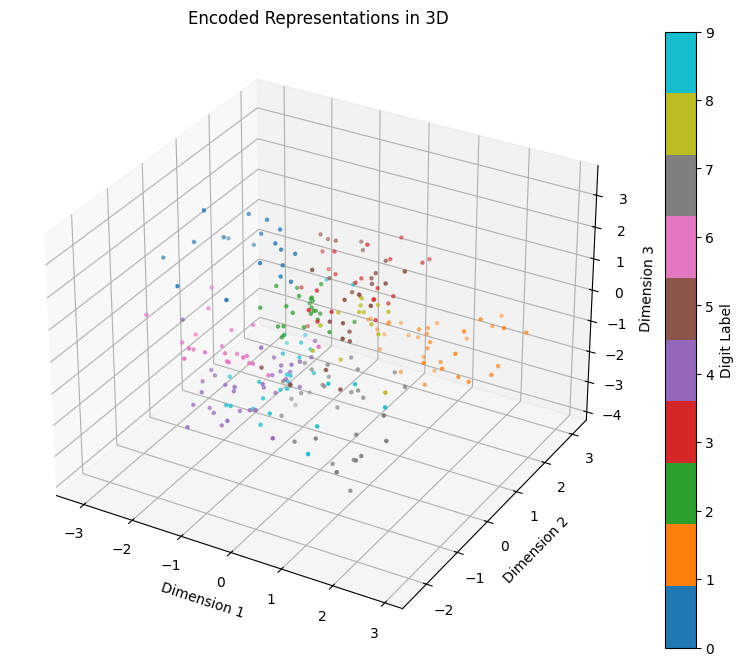

In [4]:
# Define the latent dimension
latent_dim = 3

# Initialize the model, optimizer
model = VAE(latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the VAE loss function
def vae_loss_function(recon_x, x, mean, logvar):
    recon_loss = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    return recon_loss + kl_divergence

# Train the VAE
num_epochs = 50
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for images, _ in train_loader:
        images = images.view(-1, 28*28).to(device)
        mean, logvar, z, reconstructed = model(images)
        loss = vae_loss_function(reconstructed, images, mean, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader.dataset))

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.view(-1, 28*28).to(device)
            mean, logvar, z, reconstructed = model(images)
            loss = vae_loss_function(reconstructed, images, mean, logvar)
            val_loss += loss.item()
    val_losses.append(val_loss / len(test_loader.dataset))

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")




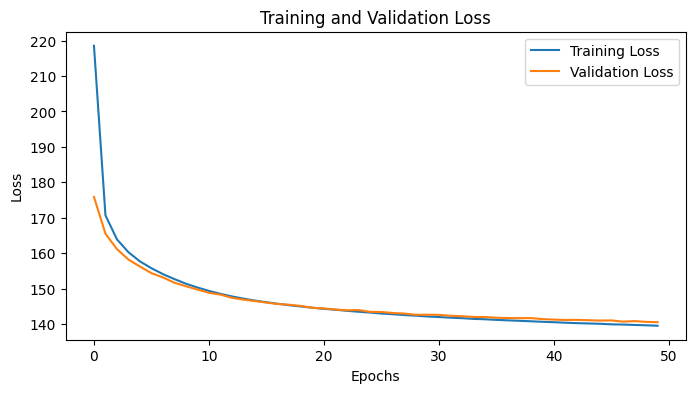

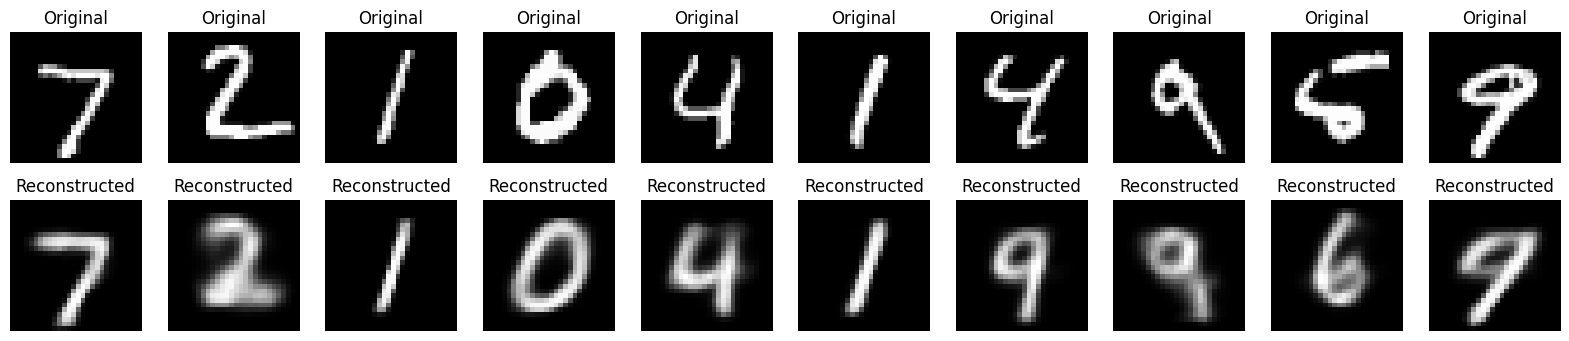

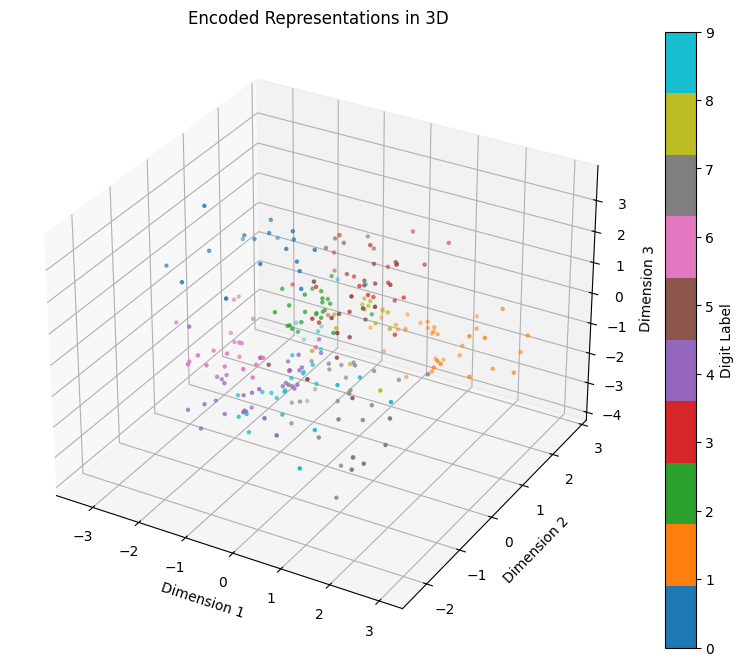

In [5]:
# Plot training and validation losses
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Visualize original and reconstructed images
model.eval()
images, labels = next(iter(test_loader))
images = images.view(-1, 28*28).to(device)
mean, logvar, z, reconstructed = model(images)
reconstructed = reconstructed.view(-1, 1, 28, 28).cpu().detach()

plt.figure(figsize=(20, 4))
for i in range(10):
    # Original image
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(images[i].view(28, 28).cpu(), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Reconstructed image
    ax = plt.subplot(2, 10, i + 11)
    plt.imshow(reconstructed[i].view(28, 28), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')
plt.show()

# Visualize the encoded representations in 3D
z = z.cpu().detach().numpy()
labels = labels.numpy()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(z[:, 0], z[:, 1], z[:, 2], c=labels, cmap='tab10', s=5)
plt.colorbar(scatter, ax=ax, label="Digit Label")
ax.set_title("Encoded Representations in 3D")
ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")
ax.set_zlabel("Dimension 3")
plt.show()